In [14]:
# standard imports
import pandas as pd
import numpy as np
import math

# prepare + acquire
from acquire_b import get_zillow_data
import prepare_b
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# exploration / visualization
import seaborn as sns
import matplotlib.pyplot as plt

# hypotheses testing
import scipy.stats as stats

# Acquire

In [15]:
# use the function to grab the data from SQL
zillow = get_zillow_data()
zillow.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc
0,1248,17305333,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,212.46,NaN,NaN,6.111002e+13,1248,11289917,-0.362001,2017-06-23,263,Mobile Home
1,1772,10838338,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6089.82,NaN,NaN,6.037128e+13,1772,11705026,-0.146056,2017-06-30,261,Single Family Residential
2,2028,10901531,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6679.55,NaN,NaN,6.037125e+13,2028,14269464,0.021085,2017-06-01,261,Single Family Residential
3,3273,11262089,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,3876.31,NaN,NaN,6.037901e+13,3273,11389003,-0.325393,2017-06-01,261,Single Family Residential
4,3429,11323134,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,4206.15,NaN,NaN,6.037901e+13,3429,11967869,-0.005566,2017-06-29,261,Single Family Residential


In [16]:
# summarize
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19667 entries, 0 to 19666
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            19667 non-null  int64  
 1   parcelid                      19667 non-null  int64  
 2   airconditioningtypeid         5759 non-null   float64
 3   architecturalstyletypeid      28 non-null     float64
 4   basementsqft                  5 non-null      float64
 5   bathroomcnt                   19667 non-null  float64
 6   bedroomcnt                    19667 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         14715 non-null  float64
 9   calculatedbathnbr             19292 non-null  float64
 10  decktypeid                    85 non-null     float64
 11  finishedfloor1squarefeet      961 non-null    float64
 12  calculatedfinishedsquarefeet  19505 non-null  float64
 13  f

**Takeaways**
- there is way too many variables
- data needs to be filtered to relevant features
- there is a ton of null values
- we can try to keep any column with 19000+ observations
- the missing values can be dropped or imputed 

---
# Prepare

In [17]:
#COME BACK AFTER MVP

# filter all of the relevant data with a mask

#column_filter = (zillow.isnull().sum() < 18000)
#columns_to_keep = zillow.columns[column_filter]
#df = zillow[columns_to_keep]
#zillow[columns_to_keep].isnull()

In [18]:
# create a dataframe from prepare file
df = prepare_b.prep_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18701 entries, 0 to 19666
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathroomcnt  18701 non-null  float64
 1   bedroomcnt   18701 non-null  int64  
 2   zipcode      18701 non-null  int64  
 3   taxamount    18701 non-null  float64
 4   home_value   18701 non-null  float64
 5   yearbuilt    18701 non-null  int64  
 6   sqft         18701 non-null  int64  
 7   county       18701 non-null  object 
 8   tax_rate     18701 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 1.4+ MB


In [19]:
# look into the numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,18701.0,2.116224,0.801057,0.00,2.00,2.00,3.00,4.50
bedroomcnt,18701.0,3.003743,0.914522,0.00,2.00,3.00,4.00,5.00
zipcode,18701.0,96499.898882,3860.132035,95982.00,96159.00,96341.00,96940.00,399675.00
taxamount,18701.0,4916.759325,4940.357059,37.65,2438.56,3864.12,5937.32,176576.49
home_value,18701.0,398634.436126,424148.759214,3257.00,180375.00,305557.00,488280.00,14721125.00
yearbuilt,18701.0,1962.034169,22.595091,1862.00,1949.00,1960.00,1979.00,2015.00
sqft,18701.0,1652.488958,707.636258,60.00,1169.00,1496.00,1964.00,9200.00
tax_rate,18701.0,1.324514,0.358748,0.01,1.19,1.24,1.36,15.51


In [20]:
# Use split function to create train, validate, and test dfs
train, validate, test = prepare_b.zillow_split(df)

train.shape, validate.shape, test.shape

((10472, 9), (4488, 9), (3741, 9))

In [21]:
# Split into X and y data frames
X_train = train.drop(columns=['home_value'])
X_validate = validate.drop(columns=['home_value'])
X_test = test.drop(columns=['home_value'])

y_train = train[['home_value']]
y_validate = validate[['home_value']]
y_test = test[['home_value']]

In [22]:
# Create scaler object
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True).fit(X_train.drop(columns='county'))

X_train_scaled = scaler.transform(X_train.drop(columns='county'))
X_validate_scaled = scaler.transform(X_validate.drop(columns='county'))
X_test_scaled = scaler.transform(X_test.drop(columns='county'))

In [23]:
#train, validate, test = prepare_b.add_scaled_columns(train, validate, test, scaler, 
                                          # train.drop(columns=['taxvaluedollarcnt', 'county', 'zipcode']).columns)
train.head()

,bathroomcnt,bedroomcnt,zipcode,taxamount,home_value,yearbuilt,sqft,county,tax_rate
3757,2.0,3,96325,3062.49,273285.0,1980,1621,Los Angeles County,1.12
11816,3.0,4,96954,14200.98,1030737.0,2014,2448,Orange County,1.38
6883,2.0,4,96524,2014.56,152322.0,1953,1134,Los Angeles County,1.32
13320,3.0,3,96387,6504.86,537067.0,1982,1794,Los Angeles County,1.21
1642,2.0,3,96403,7916.70,717821.0,1948,3014,Los Angeles County,1.10


In [24]:
# Use function to add scaled columns to dataframe
# train, validate, test = prepare_b.add_scaled_columns(train, validate, test, scaler, 
                                           #train.drop(columns=['taxvaluedollarcnt', 'county', 'zipcode']).columns)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10472 entries, 3757 to 2095
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathroomcnt  10472 non-null  float64
 1   bedroomcnt   10472 non-null  int64  
 2   zipcode      10472 non-null  int64  
 3   taxamount    10472 non-null  float64
 4   home_value   10472 non-null  float64
 5   yearbuilt    10472 non-null  int64  
 6   sqft         10472 non-null  int64  
 7   county       10472 non-null  object 
 8   tax_rate     10472 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 818.1+ KB


**takeaways**: 
- prepare_b.py
    - `fips_labels(x)` function
        - change the id values in `fips` to the county name
    - `prep_zillow(cached)` function
        - acquire zillow data
        - filter columns to use
        - drop null values
        - change categorical columns to integers
        - rename columns for readability
            - `regionidzip` $\rightarrow$ `zipcode`
            - `calculatedfinishedsquarefeet` $\rightarrow$ `sqft`
            - `taxvaluedollarcnt` $\rightarrow$ `home_value`
        - add `county` column
        - create `tax_rate` feature = $\frac{taxamount}{taxvaluedollaramt}$
        - drop `fips` column
        - dropped rows with more then 5 bedrooms, 4 bathrooms 
    - `zillow_split(df)` function
        - split into train, validate, test datasets
    - `add_scaled_columns(train, validate, test, scaler, columns_to_scale)`
        - add scaled columns for continuous variables to all datasets as a dataframe

---
# Exploration

In [25]:
# plt rc sets defaults for matplotlib figures
plt.rc("font", size=13)
plt.rc("figure", figsize= (13,7))

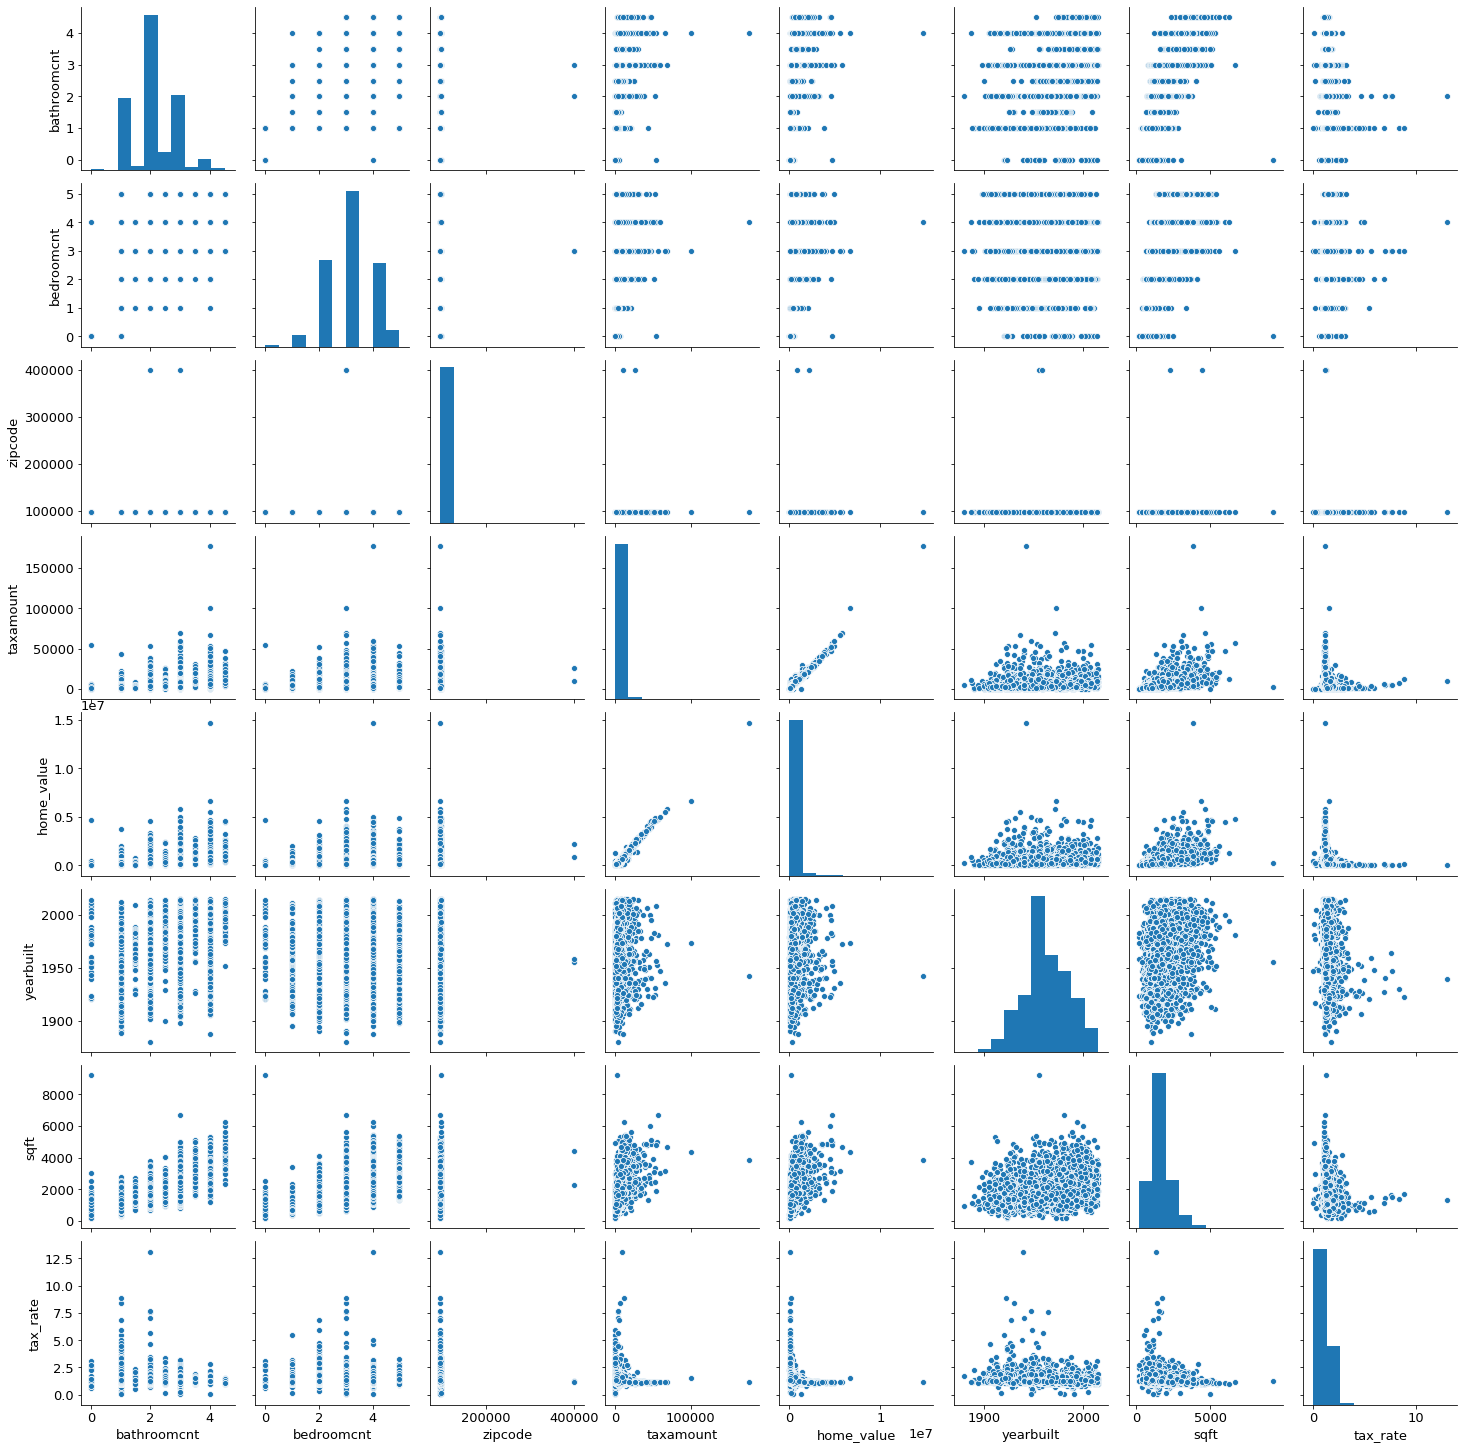

In [26]:
#Visualize all variable relationships
sns.pairplot(train)

In [27]:
# look into numerical stats data again
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,10472.0,2.119223,0.795898,0.00,2.0000,2.00,3.00,4.50
bedroomcnt,10472.0,3.007448,0.916608,0.00,2.0000,3.00,4.00,5.00
zipcode,10472.0,96506.103514,4208.336228,95982.00,96151.0000,96341.00,96533.00,399675.00
taxamount,10472.0,4902.712172,4829.282965,82.72,2436.6925,3852.34,5923.42,176576.49
home_value,10472.0,397225.894958,413920.384964,7106.00,180139.5000,305877.50,486248.25,14721125.00
yearbuilt,10472.0,1961.958174,22.756839,1880.00,1949.0000,1959.00,1979.00,2015.00
sqft,10472.0,1653.385122,708.240360,171.00,1172.0000,1491.00,1960.25,9200.00
tax_rate,10472.0,1.325755,0.351721,0.03,1.1900,1.24,1.36,13.09


In [33]:
train.nunique()

bathroomcnt        9
bedroomcnt         6
zipcode          380
taxamount      10402
home_value      9468
yearbuilt        124
sqft            2645
county             3
tax_rate         255
dtype: int64

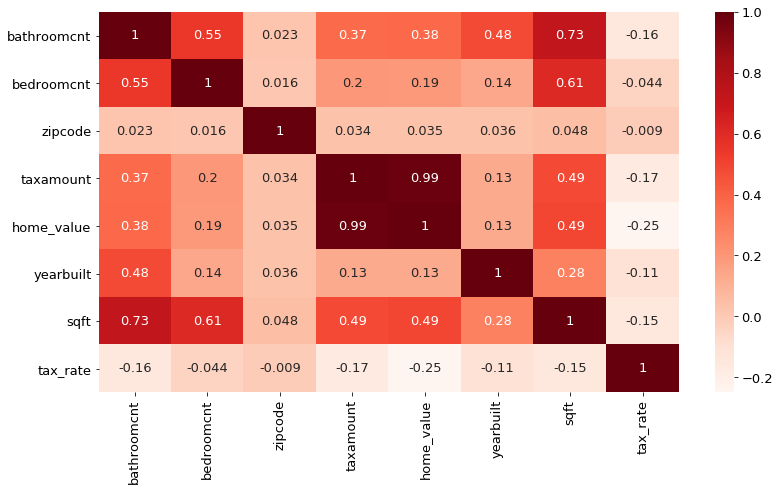

In [28]:
# looking at correlation for all variables
sns.heatmap(train.corr(), cmap='Reds', annot=True)

(0, 2000000)

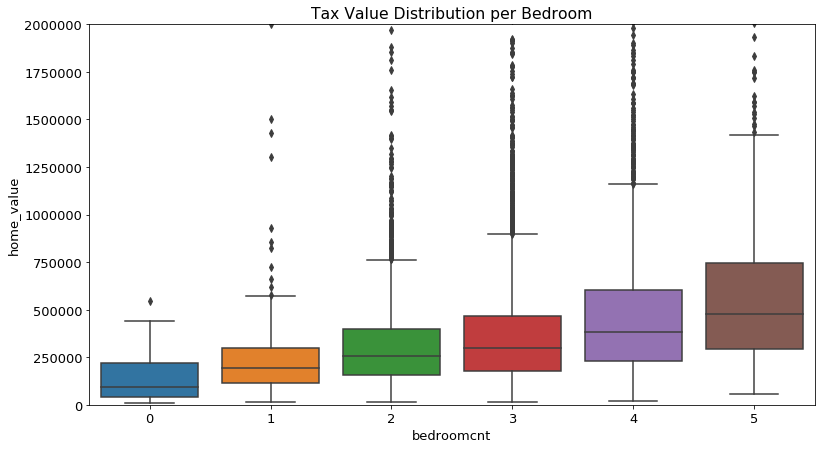

In [40]:
# visualize distribution with box plot
sns.boxplot(data=train, y='home_value', x='bedroomcnt')
plt.title('Tax Value Distribution per Bedroom')
plt.ylim(0, 2_000_000)

Text(0.5, 1.0, 'Tax Rate per County')

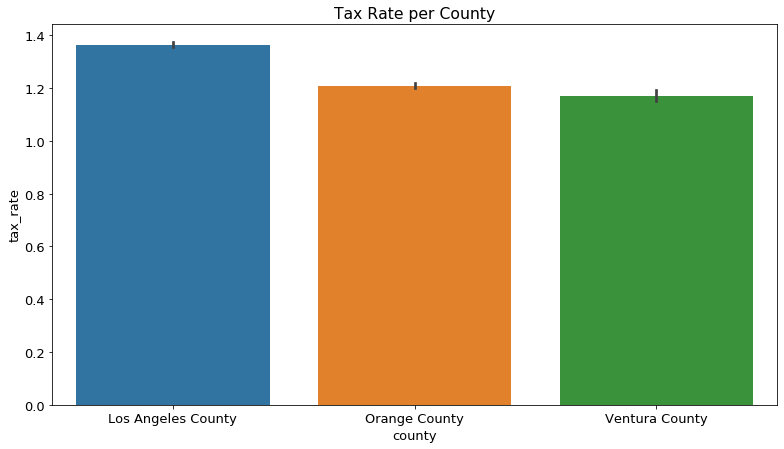

In [37]:
# visualize mean tax rate for each county
sns.barplot(data=train, y='tax_rate', x='county')
plt.title('Tax Rate per County')

Text(0.5, 1.0, 'Count of Single Unit Homes in each County')

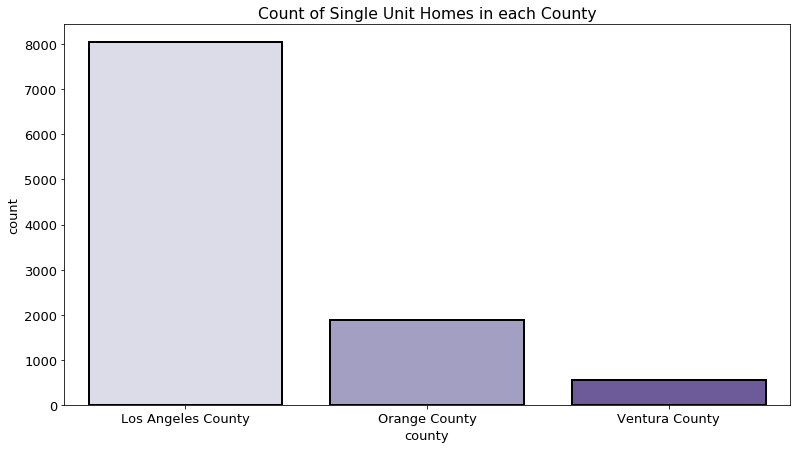

In [32]:
# visualize the number of single unit homes for each county
sns.countplot(x = 'county', data=train, palette='Purples', ec='black', linewidth=2)
plt.title('Count of Single Unit Homes in each County')

**takeaways**
- catgorical variables
    - `bedroomcnt`
    - `county`
- continuous variables
    - `bathroomcnt`
    - `taxamount`
    - `home_value`
    - `yearbuilt`
    - `sqft`
    - `county`
    - `tax_rate`
    
- there are several outliers in the data in terms of `home_value`
- `tax_rate` seems to be higher in LA County
- LA county has a lot more homes than anywhere else

___
## Hypothesis Tests

Does LA County have a higher average tax rate than the overall population?

### One Sample Single-Tailed T-Test

Text(0.5, 1.0, 'Distribution of Population Home Values')

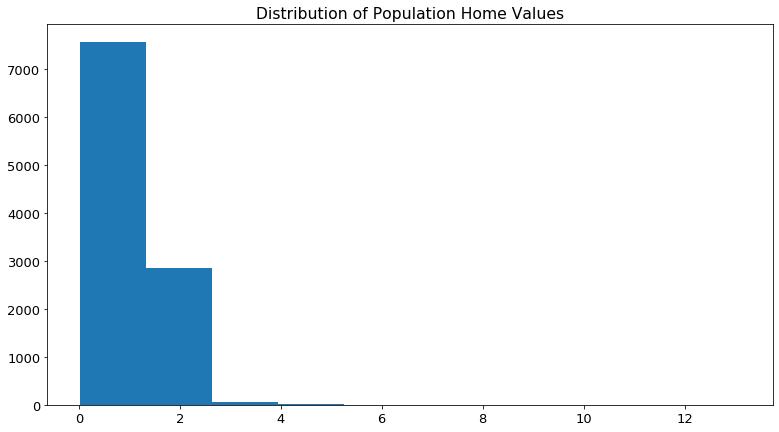

In [41]:
plt.hist(train.tax_rate)
plt.title('Distribution of Population Home Values')

Text(0.5, 1.0, 'Distribution of LA County Home Values')

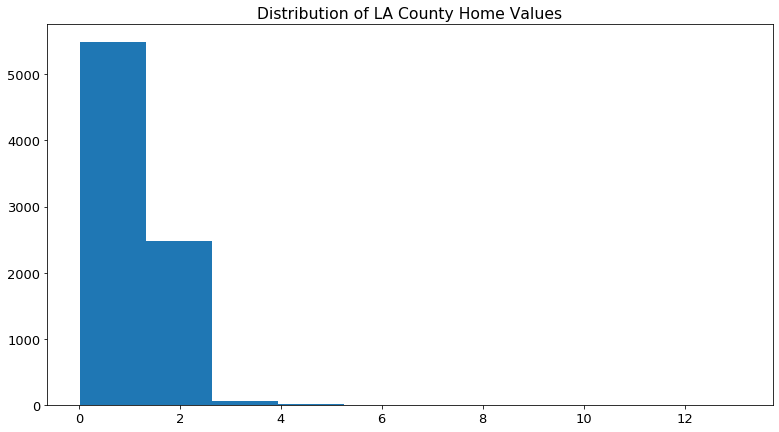

In [42]:
plt.hist(train.tax_rate[train.county == 'Los Angeles County'])
plt.title('Distribution of LA County Home Values')

**Hypotheses**

$H_0$: mean tax rate Los Angeles County <= the overall population of assessed counties

$H_a$: mean tax rate Los Angeles County > the overall population of assessed counties

In [51]:
null_ost = 'the mean tax rate Los Angeles County <= the overall population of assessed counties'

# set a significance level
alpha = .05

# verify assumptions
train.county.value_counts()

Los Angeles County    8042
Orange County         1887
Ventura County         543
Name: county, dtype: int64

**Compute T-Statistic and P-Value**

In [53]:
overall_mean = train.tax_rate.mean()
sample_mean = train.tax_rate[train.county == 'Los Angeles County']

t, p = stats.ttest_1samp(sample_mean, overall_mean)
print('T-statistic: ', t)
print('P-value: ', p/2)

T-statistic:  9.146310451480641
P-value:  3.674899460100822e-20


**Decision**

In [54]:
if p/2 > alpha:
    print("We fail to reject H_0 that", null_ost)
elif t < 0:
    print("We fail to reject H_0 that", null_ost)
else:
    print("We reject H_0 that", null_ost)

We reject H_0 that the mean tax rate Los Angeles County <= the overall population of assessed counties


---
### Correlation Test

Is there a linear relationship between bathroom and bedroom count?

Text(0.5, 1.0, 'Square Footage vs. Tax Amount')

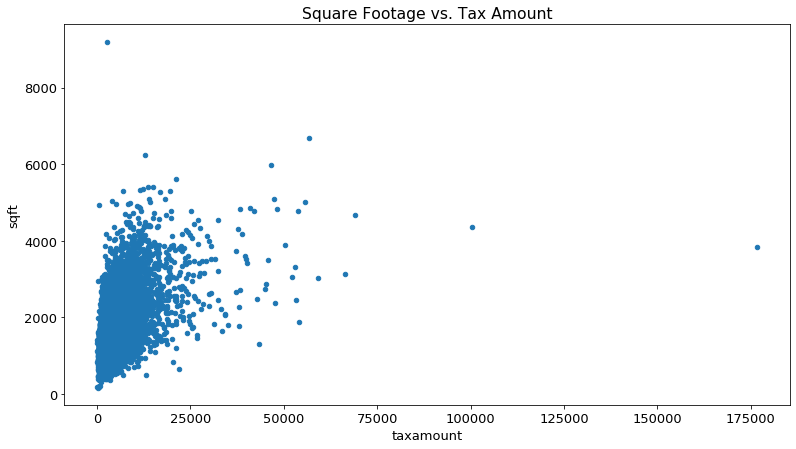

In [55]:
train.plot.scatter(y='sqft', x='taxamount')
plt.title('Square Footage vs. Tax Amount')

**Hypotheses**

$H_0$: There is no linear relationship between square footage and tax amount

$H_a$: There is a linear relationship between square footage and tax amount

In [56]:
null_ct = 'there is no linear relationship between square footage and tax amount'

# set a significance level
alpha = .05

x = train.taxamount
y = train.sqft

**Compute T-Statistic and P-Value**

In [57]:
r, p = stats.pearsonr(x, y)
print('r =', r)
print('p =', p)

r = 0.48697520969008457
p = 0.0


**Decision**

In [58]:
if p > alpha:
    print("We fail to reject H_0 that", null_ct)
else:
    print("We reject H_0 that", null_ct)

We reject H_0 that there is no linear relationship between square footage and tax amount


**Takeaways**: 
- the mean `tax_rate` is greater in LA County than the population mean

- there is a decent linear relationship between `sqft` and `taxamount`